### Time to get your hands dirty! Cloning quasars
Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

- Download the SDSS quasar data
- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)
- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

In [1]:
import numpy as np
from astroML.datasets import fetch_dr7_quasar
from matplotlib import pyplot as plt
import scipy.stats
import scipy.interpolate as interpolate
from scipy.interpolate import splev, splrep
import astropy

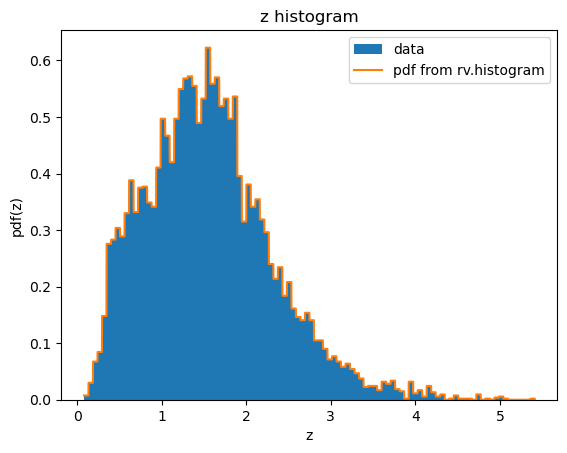

In [4]:
# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']
z_hist = np.histogram(z, bins = 100)
z_dist = scipy.stats.rv_histogram(z_hist)

z_lin = np.linspace(min(z), max(z), 10000)

#plot istogramma e cumulativa
ax = plt.gca()
plt.hist(z, bins = 100, density = True, label = 'data')
ax.plot(z_lin, z_dist.pdf(z_lin), label = 'pdf from rv.histogram')
plt.title('z histogram')
plt.xlabel('z')
plt.ylabel('pdf(z)')
plt.legend()
plt.show()

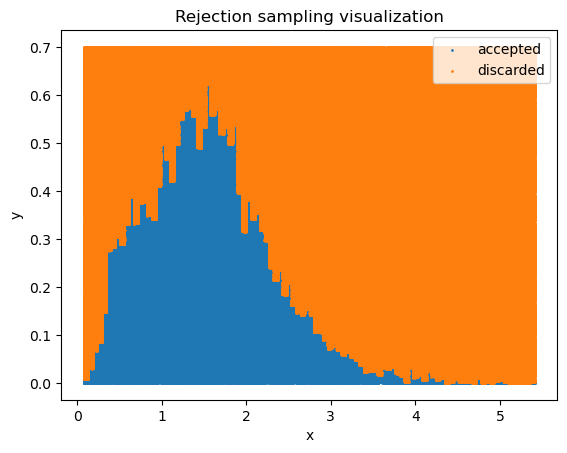

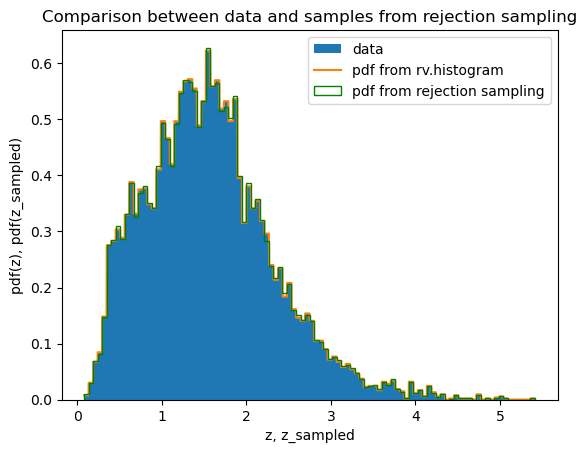

In [5]:
# =============================================================================
# PARTE 1: REJECTION SAMPLING
# =============================================================================
#visualizzazione del rejection sampling
x = np.random.uniform(min(z),max(z),1000000)
y = np.random.uniform(0, 0.7,1000000)

plt.scatter(x[y<z_dist.pdf(x)],y[y<z_dist.pdf(x)], s = 0.9, label ='accepted')
plt.scatter(x[y>z_dist.pdf(x)],y[y>z_dist.pdf(x)], s = 0.9, label = 'discarded')
plt.title('Rejection sampling visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc = 'upper right')
plt.show()

#scelta dei punti validi e confronto con distribuzione iniziale
goodpoints = x[y<z_dist.pdf(x)]
ax = plt.gca()
plt.hist(z, bins = 100, density = True, label = 'data')
ax.plot(z_lin, z_dist.pdf(z_lin), label = 'pdf from rv.histogram')
plt.hist(goodpoints,bins=100,density=True,histtype='step', color = 'green', label = 'pdf from rejection sampling')
plt.title('Comparison between data and samples from rejection sampling')
plt.xlabel('z, z_sampled')
plt.ylabel('pdf(z), pdf(z_sampled)')
plt.legend()
plt.show()

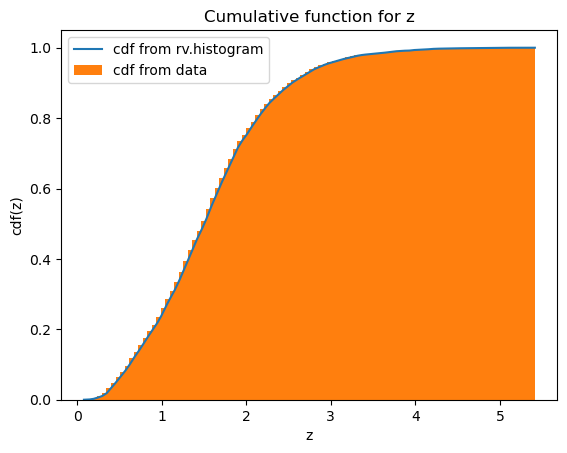

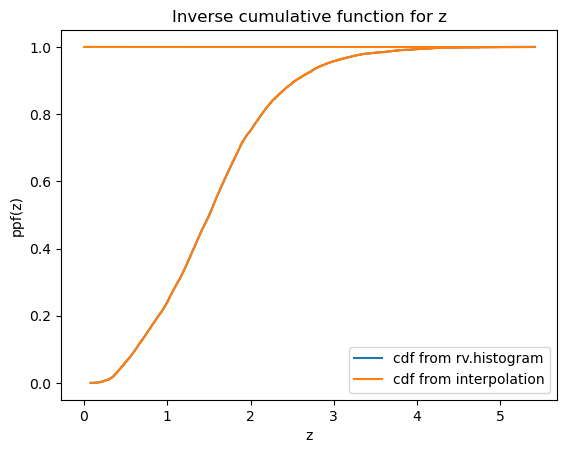

In [7]:
# =============================================================================
# PARTE 2: INVERSE TRANSFORM SAMPLING; in questo caso ho bisogno di calcolare
# anche la cumulativa e la inverse cumulative function. Utilizzo il metodo
# rv.histogram per controllare i risultati ottenuti per cdf e icf tramite
# interpolazione, ma in realtà sarebbero equivalenti
# =============================================================================

#plot cumulativa
ax = plt.gca()
ax.plot(z_lin, z_dist.cdf(z_lin), label = 'cdf from rv.histogram')
plt.hist(z, bins = 100, density = True, cumulative = True, label = 'cdf from data')
plt.title('Cumulative function for z')
plt.xlabel('z')
plt.ylabel('cdf(z)')
plt.legend()
plt.show()

#interpolo cdf e icf
z_cumulative = np.linspace(0,1, 10000)
z.sort()
#tck contiene un array con la cdf, un array con le z, e un terzo vettore che non so a cosa si riferisca
tck = interpolate.splrep(z_cumulative, z) #chiedi al prof perché è un array di lunghezza 10004 invece che 10000

Pz_cumulative = np.linspace(0,1, 10000)
#z_sample sono il risultato dell'inverse transform sampling
z_sample = interpolate.splev(Pz_cumulative, tck)

#plot cumulativa - confronto interpolazione/rv.histogram
ax = plt.gca()
ax.plot(z_lin, z_dist.cdf(z_lin), label = 'cdf from rv.histogram')
plt.plot(tck[1], tck[0], label = 'cdf from interpolation') 
plt.title('Inverse cumulative function for z')
plt.xlabel('z')
plt.ylabel('ppf(z)')
plt.legend()
plt.show()

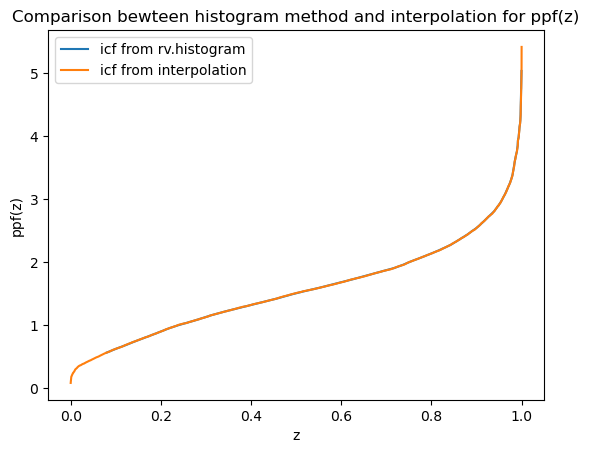

In [8]:
#plot inverse cumulative function - confronto interpolazione/rv.histogram
ax = plt.gca()
ax.plot(z_lin, z_dist.ppf(z_lin), label='icf from rv.histogram')
plt.plot(Pz_cumulative, z_sample, label='icf from interpolation')
plt.title('Comparison bewteen histogram method and interpolation for ppf(z)')
plt.xlabel('z')
plt.ylabel('ppf(z)')
plt.legend()
plt.show()

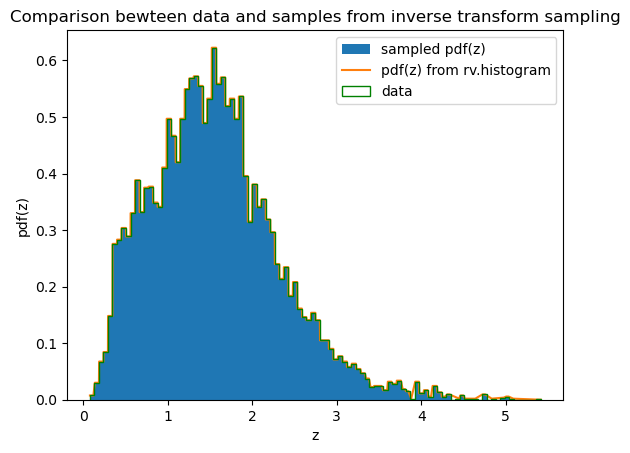

In [9]:
#plot istogramma dei nuovi redshift e confronto con pdf distribuzione iniziale (dai dati e da rv.histogram)
plt.hist(z_sample, bins = 100, density = True, label = 'sampled pdf(z)')
plt.plot(z_sample, z_dist.pdf(z_sample), label = 'pdf(z) from rv.histogram')
plt.hist(z, bins = 100, density = True, histtype='step',color='green', label='data')
plt.title('Comparison bewteen data and samples from inverse transform sampling')
plt.xlabel('z')
plt.ylabel('pdf(z)')
plt.legend()
plt.show()

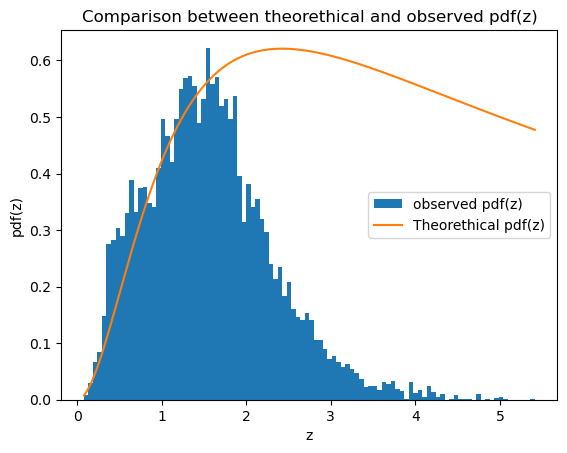

In [10]:
#tentativo di ricavare la distribuzione delle quasar
cosmo = astropy.cosmology.Planck18
#uso il differential comoving volume perché mi serve il dv, non tutto il volume sotteso
distribution = cosmo.differential_comoving_volume(z_lin).value
distribution = distribution/(sum(distribution))

plt.hist(z, bins = 100, density = True, label = 'observed pdf(z)')
plt.plot(z_lin, 1e4/2*distribution, label = 'Theorethical pdf(z)')
plt.xlabel('z')
plt.ylabel('pdf(z)')
plt.title('Comparison between theorethical and observed pdf(z)')
plt.legend()